In [1]:
import random
import numpy as np
import tqdm
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_unitary, Operator
from qiskit.circuit.library import IGate, XGate, RZGate, RZZGate
from qiskit.circuit import Delay, Barrier, Parameter, Measure
from qiskit.converters import dag_to_circuit
from qiskit.transpiler.synthesis.aqc import AQCSynthesisPlugin

τ = Parameter('τ')

def build_circuits(reps, layers):
    circuits = []
    circuits_joint = []
    for l in tqdm.tqdm(layers):
        rep_circuits = []
        rep_circuits_joint = []
        for _ in range(reps):
            c = QuantumCircuit(3, 3)
            c_joint = QuantumCircuit(3, 3)
            su8s = []
            for i in range(l):
                seed_u = random.randint(1, 1000)
                u = random_unitary(4, seed=seed_u).to_instruction()
                u.label = "U_" + str(seed_u)
                su8s.append(Operator(IGate()) ^ Operator(u))

                seed_v = random.randint(1, 1000)
                v = random_unitary(4, seed=seed_v).to_instruction()
                v.label = "V_" + str(seed_v)
                su8s.append(Operator(v) ^ Operator(IGate()))

                # bare
                c.append(u, [0, 1])
                c.barrier(0, 1)
                c.append(v, [1, 2])
                c.barrier(1, 2)
                c.append(Delay(τ, 's'), [0])
                c.append(Delay(τ, 's'), [1])
                c.append(Delay(τ, 's'), [2])
                # joint
                c_joint.append(u, [0, 1])
                c_joint.barrier(0, 1)
                c_joint.append(v, [1, 2])
                c_joint.append(Delay(τ, 's'), [0, 1, 2])


            inverse_su8 = Operator(IGate()) ^ Operator(IGate()) ^ Operator(IGate())
            for su8 in su8s:
                inverse_su8 = inverse_su8.compose(su8, front=False)
            inverse_su8 = inverse_su8.adjoint()
            decomposer = AQCSynthesisPlugin()
            inverse_qc = dag_to_circuit(decomposer.run(inverse_su8.data, options={'network_layout': 'spin'}))

            c.append(inverse_qc, [0, 1, 2])
            c_joint.append(inverse_qc, [0, 1, 2])

            for i in range(3):
                c.append(Measure(), [i], [i])
                c_joint.append(Measure(), [i], [i])

            rep_circuits.append(c)
            rep_circuits_joint.append(c_joint)

        circuits.append(rep_circuits)
        circuits_joint.append(rep_circuits_joint)
    return circuits, circuits_joint

In [2]:
reps = 5                      # stochastic reps of the same depth
layers = [10]   # number of layers to build circuits from

circuits, circuits_joint = build_circuits(reps, layers)

100%|██████████| 1/1 [00:33<00:00, 33.31s/it]


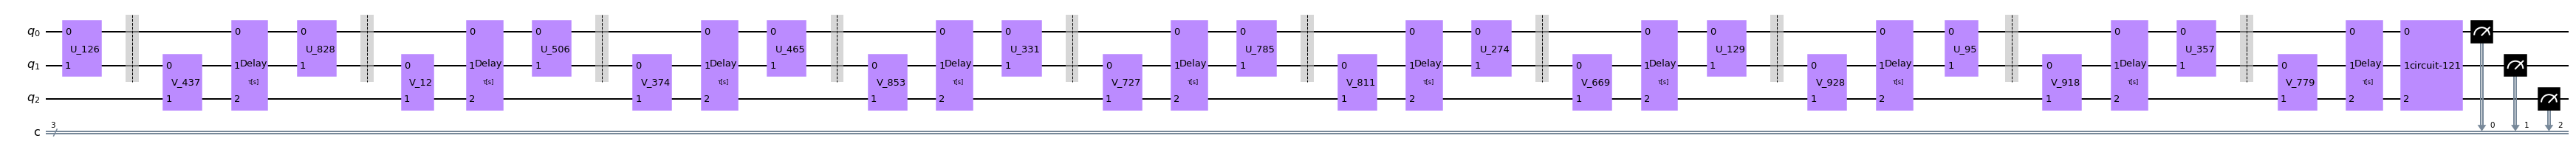

In [67]:
circuits[0][0].draw('mpl', fold=-1)
circuits_joint[0][0].draw('mpl', fold=-1)

In [3]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.backend.ibmq_mumbai

In [4]:
from qiskit import transpile
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler import InstructionDurations
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes import (ALAPScheduleAnalysis, TimeUnitConversion,
                                      ConstrainedReschedule, PadDynamicalDecoupling, PadDelay)


def alap(c, backend):
    instruction_durations = InstructionDurations.from_backend(backend)
    timing_constraints = TimingConstraints(**backend.configuration().timing_constraints)
    pm = PassManager(
        [
            TimeUnitConversion(instruction_durations),
            ALAPScheduleAnalysis(instruction_durations),
            ConstrainedReschedule(acquire_alignment=timing_constraints.acquire_alignment,
                                  pulse_alignment=timing_constraints.pulse_alignment),
            PadDelay()
        ]
    )
    return pm.run(c)

def decouple_normal(c, backend):
    instruction_durations = InstructionDurations.from_backend(backend)
    timing_constraints = TimingConstraints(**backend.configuration().timing_constraints)
    pm = PassManager(
        [
            TimeUnitConversion(instruction_durations),
            ALAPScheduleAnalysis(instruction_durations),
            ConstrainedReschedule(acquire_alignment=timing_constraints.acquire_alignment,
                                  pulse_alignment=timing_constraints.pulse_alignment),
            PadDynamicalDecoupling(durations=instruction_durations, 
                                   dd_sequence=[XGate(), RZGate(np.pi), XGate(), RZGate(-np.pi)],
                                   spacing = [1/4, 1/2, 0, 0, 1/4],
                                   pulse_alignment=timing_constraints.pulse_alignment)
        ]
    )
    return pm.run(c)

def decouple_multi_qubit_delay(sc, backend):
    '''A scheduled circuit but with a remaining multi-qubit delay which we now decouple.'''
    new_sc = QuantumCircuit(len(sc.qubits), len(sc.clbits))
    instruction_durations = InstructionDurations.from_backend(backend)
    len_x = instruction_durations.get('x', (0,))
    for op, qubits, clbits in sc:
        if isinstance(op, Delay) and len(qubits) > 1:
            slack = op.duration - 2 * len_x
            for q in qubits:
                if q.index % 2 != 0:
                    new_sc.append(Delay(int(slack/2), 'dt'), [q])
                    new_sc.append(XGate(), [q])
                    new_sc.append(Delay(int(slack/2), 'dt'), [q])
                    new_sc.append(RZGate(np.pi), [q])
                    new_sc.barrier(q)
                    new_sc.append(XGate(), [q])
                    new_sc.barrier(q)
                    new_sc.append(RZGate(-np.pi), [q])
                else:
                    new_sc.append(Delay(int(slack/4), 'dt'), [q])
                    new_sc.append(XGate(), [q])
                    new_sc.append(Delay(int(slack/2), 'dt'), [q])
                    new_sc.append(RZGate(np.pi), [q])
                    new_sc.barrier(q)
                    new_sc.append(XGate(), [q])
                    new_sc.barrier(q)
                    new_sc.append(RZGate(-np.pi), [q])
                    new_sc.append(Delay(int(slack/4), 'dt'), [q])
        else:
            new_sc.append(op, qubits, clbits)
    new_sc = transpile(new_sc, backend, scheduling_method='alap', translation_method='synthesis')
    return new_sc

def compile_experiments(backend, qubits, τ_values):
    # bind
    flat_circuits = [c.assign_parameters({τ: τ_value})
                     for τ_value in τ_values for rep_circuits in circuits for c in rep_circuits]
    # flat_circuits_joint = [c.assign_parameters({τ: τ_value})
    #                       for τ_value in τ_values for rep_circuits in circuits_joint for c in rep_circuits]
    
    # rewrite in basis
    basis_gates = backend.configuration().basis_gates
    flat_circuits = transpile(flat_circuits, basis_gates=basis_gates, initial_layout=qubits)
    # flat_circuits_joint = transpile(flat_circuits_joint, basis_gates=basis_gates, initial_layout=qubits)

    # schedule and insert DD
    # flat_circuits_bare = [alap(c, backend) for c in flat_circuits]
    flat_circuits_dd = [decouple_normal(c, backend) for c in flat_circuits]
    # flat_circuits_multi = [decouple_multi_qubit_delay(alap(c, backend), backend) for c in flat_circuits_joint]
    # flat_circuits_multi_dd = [decouple_multi_qubit_delay(decouple_normal(c, backend), backend) for c in flat_circuits_joint]
    
    # list of circuits for the experiment (1 job)
    # experiments = [x for t in zip(flat_circuits_bare, flat_circuits_dd, 
    #                               flat_circuits_multi, flat_circuits_multi_dd) for x in t]
    experiments = [x for t in zip(flat_circuits_dd) for x in t]
    
    return experiments

In [39]:
qubits = [0, 1, 2]
τ_values = np.linspace(1e-12, 1e-4, 60 * 20) 
τ_values = np.reshape(τ_values, (20, 60))
shots = 1000
experiments = []
for τ_value in τ_values:
    experiments.append(compile_experiments(backend, qubits, τ_value))

/Users/georgezhou/miniforge3/envs/DDResearch/lib/python3.9/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 0 [dt] = 0.000000e+00 [s] from 1.000000e-12 [s]
  warnings.warn(
/Users/georgezhou/miniforge3/envs/DDResearch/lib/python3.9/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 375 [dt] = 8.333333e-08 [s] from 8.340383e-08 [s]
  warnings.warn(
/Users/georgezhou/miniforge3/envs/DDResearch/lib/python3.9/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 751 [dt] = 1.668889e-07 [s] from 1.668067e-07 [s]
  warnings.warn(
/Users/georgezhou/miniforge3/envs/DDResearch/lib/python3.9/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 1126 [dt] = 2.502222e-07 [s] from 2.502095e-07 [s]
  warnings.warn(
/Users/georgezhou/miniforge3/envs/DDResearch/lib/python3.9/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 1501 [dt] = 3.335556e-07 [s] from

In [41]:
jobs = []
i = 0
for experiment, τ_value in zip(experiments, τ_values):
    job = backend.run(experiment, shots=shots)
    job.update_name(f'Duration Test {i}')
    job.update_tags([f'device: {backend.name}',
                    f'qubits: {qubits}',
                    f'gap: {τ_value}', 
                    f'cx1: {round(backend.properties().gate_length("cx", qubits[:2])*1e9, 2)}',
                    f'cx2: {round(backend.properties().gate_length("cx", qubits[1:])*1e9, 2)}',
                    f'x: {round(backend.properties().gate_length("x", qubits[0])*1e9, 2)}',
                    f'shots: {shots}',
                    f'reps: {reps}',
                    f'layers: {layers}'])
    i += 1
    job.wait_for_final_state()   
    jobs.append(job)

In [36]:
from scipy.optimize import curve_fit
import scipy as sp
from matplotlib import pyplot as plt
import numpy as np
import re

def parse_tags(tags):
    for t in tags:
        if t.startswith('device'):
            device = t.split(': ')[1]
        if t.startswith('gap'):
            split = re.split(':| |,|\[|\]', t)
            gaps = [float(i) for i in list(filter(bool, split))[1:]]
        if t.startswith('cx1'):
            cx1 = float(t.split(': ')[1])
        if t.startswith('cx2'):
            cx2 = float(t.split(': ')[1])
        if t.startswith('x'):
            x = float(t.split(': ')[1])
        if t.startswith('qubits'):
            q0 = int(re.split(': |,|\s|\[|\]', t)[2])
            q1 = int(re.split(': |,|\s|\[|\]', t)[4])
        if t.startswith('shots'):
            shots = int(t.split(': ')[1])
        if t.startswith('reps'):
            reps = int(t.split(': ')[1])
        if t.startswith('layers'):
            split = re.split(':| |,|\[|\]', t)
            layers =[int(i) for i in list(filter(bool, split))[1:]]
    return [device, [q0, q1], gaps, cx1, cx2, x, shots, reps, layers]

def plot_job(jobs):
    # if not job.done():
    #     raise Exception(f'Job not done. Status: {job.status()}.')
    # if job.name() != 'Duration Test':
    #     raise Exception('Job doesnt belong to this notebook.')

    res = []
    tags = {
        'device' : backend.name,
        'qubits' : qubits,
        'gaps' : [],
        'cx1' : [],
        'cx2' : [],
        'x' : [],
        'shots' : shots,
        'reps' : reps,
        'layers' : layers
    }
    total_circuits = None
    num_curves = 1
    for job in jobs:
        res.append(job.result(refresh=True))
        _, _, gaps, cx1, cx2, x, _, _, _ = parse_tags(job.tags())
        tags['gaps'].extend(gaps)
        tags['cx1'].append(cx1)
        tags['cx2'].append(cx2)
        tags['x'].append(x)
        total_circuits = reps * len(gaps) * num_curves

    # p0 = [[res.get_counts(j)['000'] for j in range(i, i+num_curves*reps, num_curves)] for i in range(0, total_circuits, num_curves*reps)]
    p0_dd = []
    # p0_dd_joint = [[res.get_counts(j)['000'] for j in range(i, i+num_curves*reps, num_curves)] for i in range(2, total_circuits, num_curves*reps)]
    # p0_dd_both = [[res.get_counts(j)['000'] for j in range(i, i+num_curves*reps, num_curves)] for i in range(0, total_circuits, num_curves*reps)]
    for r in res:
        data_points = [[r.get_counts(j)['000'] for j in range(i, i+num_curves*reps, num_curves)] for i in range(0, total_circuits, num_curves*reps)]
        p0_dd.extend(data_points)


    fig = plt.figure(figsize=(15, 10))
    # plot_order = [p0_dd_both, p0_dd_joint, p0_dd, p0]
    # label_order = ['DD both', 'DD joint', 'DD', 'bare']
    plot_order = [p0_dd]
    label_order = ['DD']
    print(len([at_rep/shots for at_l in p0_dd for at_rep in at_l]))
    # for data, label in zip(plot_order, label_order):
    #     means = [np.mean(data[i])/shots for i in range(len(data))]
    #     # fitcurve, popt = fitexp(layers, means)
    #     # decay = round(popt[1], 2)
    #     plt.scatter(tags['gaps'], [at_rep/shots for at_l in data for at_rep in at_l])
    #     # plt.plot(layers, fitcurve, label=f'{label} [{decay}]')
    #     plt.plot(gaps, means)
    means = [np.mean(p0_dd[i])/shots for i in range(len(p0_dd))]
    # plt.scatter([gap for gap in tags['gaps'] for _ in range(reps)], [at_rep/shots for at_l in p0_dd for at_rep in at_l])
    plt.plot(tags['gaps'], means)

    plt.ylabel('P(000)', fontsize=16)
    plt.xlabel('τ', fontsize=16)
    plt.legend(fontsize=16)
    # plt.title(f'device: {backend.name}, qubits: {qubits}, cx1: {cx1} ns, cx2: {cx2} ns, x: {x} ns, layers: {layers[0]}', 
    #           fontsize=16)
    plt.title(f'device: {backend.name}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6000


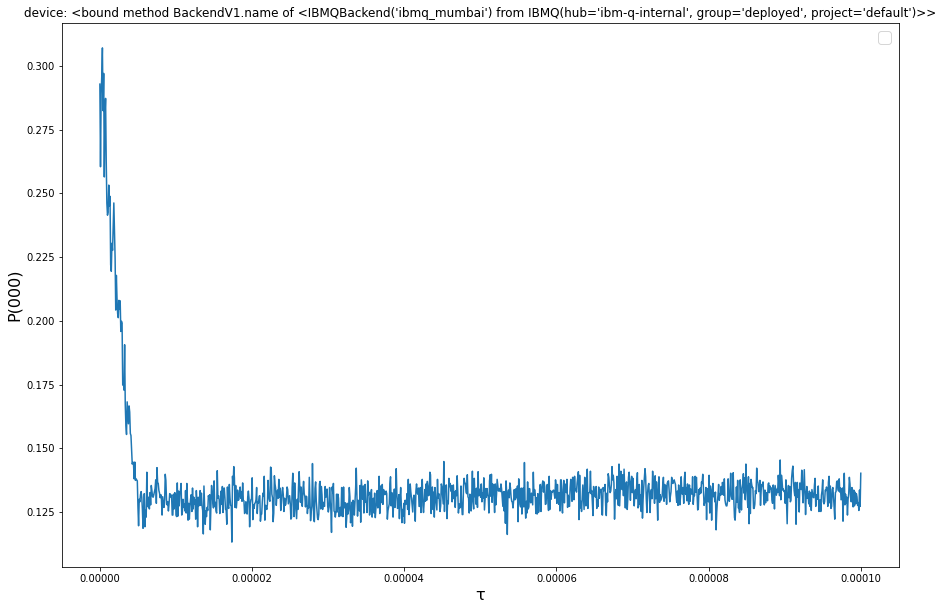

In [42]:
plot_job(jobs)